# Digital House - Data Science a Distancia

## Trabajo Práctico 2



### Autores: Nahuel Bonfante, Daniel Borrino, Ivan Mongi, Jessica Polakoff, Julio Tentor

<p style="text-align:right;">Mayo 2022</p>

#### Aspectos técnicos
La notebook se ejecuta correctamente en una instalación estándar de Anaconda versión 4.11.0 build  3.21.6, Python 3.9.7


#### Librerías necesarias

In [1]:
import numpy as np
import pandas as pd
import re

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
import statsmodels.api as sm

In [5]:
# Ignore some warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

---
#### Dataset

In [6]:
data_final_url = "../Data/properatti_final.csv"
data = pd.read_csv(data_final_url, encoding="utf-8")


In [7]:
mask = data['state_name'] == 'Capital Federal'
mask = np.logical_and(mask, data['property_type'] == 'apartment')
data = data[mask].copy()

mask = data['place_name'] == 'Belgrano'
mask = np.logical_or(mask, data['place_name'] == 'Palermo')
mask = np.logical_or(mask, data['place_name'] == 'Recoleta')
data = data[mask].copy()


---
#### Seleccionar, renombrar y ajustar valores de las características

In [8]:
data.reset_index(inplace=True)

In [9]:
data.rename(columns={'property_type' : 'tipo'}, inplace=True)
data.rename(columns={'price_aprox_usd' : 'precio'}, inplace=True)
data.rename(columns={'surface_covered_in_m2' : 'superficie'}, inplace=True)

In [10]:
# Trabajar con precio en miles de dólares
data['precio'] = (data['precio'] / 1000).round(3)

---

In [11]:
data.shape

(4718, 11)

In [12]:
data.head()

,index,Unnamed: 0,tipo,place_name,state_name,precio,superficie,cochera,pileta,parrilla,ambientes_final
0,2,7,apartment,Belgrano,Capital Federal,138.0,40.0,0,1,0,NaN
1,3,8,apartment,Belgrano,Capital Federal,195.0,60.0,0,1,0,NaN
2,8,19,apartment,Palermo,Capital Federal,350.0,96.0,0,0,0,3.0
3,9,21,apartment,Palermo,Capital Federal,270.5,73.0,0,0,0,4.0
4,64,120,apartment,Belgrano,Capital Federal,178.0,55.0,1,0,0,NaN


In [13]:
data['place_name'].value_counts()

Belgrano    1866
Palermo     1744
Recoleta    1108
Name: place_name, dtype: int64

---


In [14]:

sns.set()
plt.style.use('seaborn')

sns.mpl.rcParams['axes.titlesize'] = 20
sns.mpl.rcParams['axes.labelsize'] = 16


In [15]:
features = ['precio', 'superficie', 'cochera', 'pileta', 'parrilla']

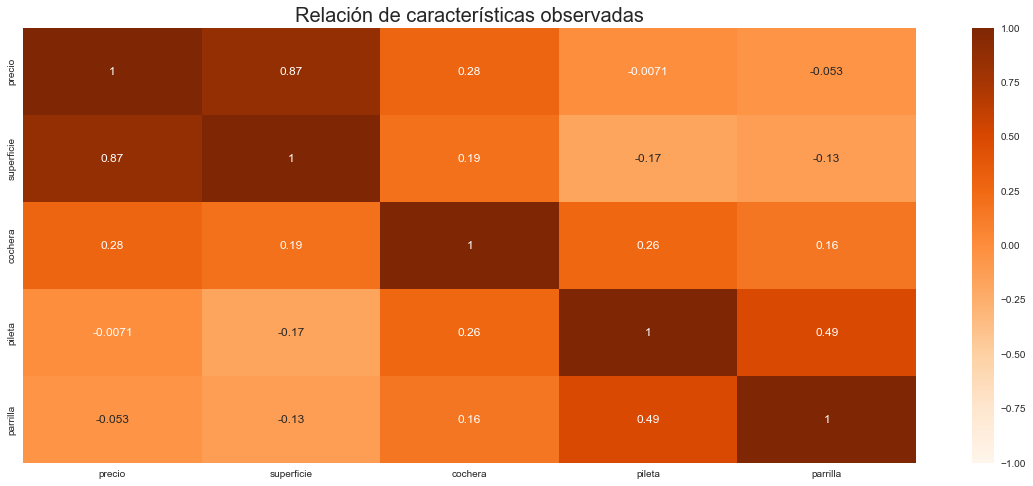

In [16]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(data[features].corr(), annot=True, vmin=-1, vmax=1, cmap='Oranges', ax=ax)
ax.set(title='Relación de características observadas')
plt.show()

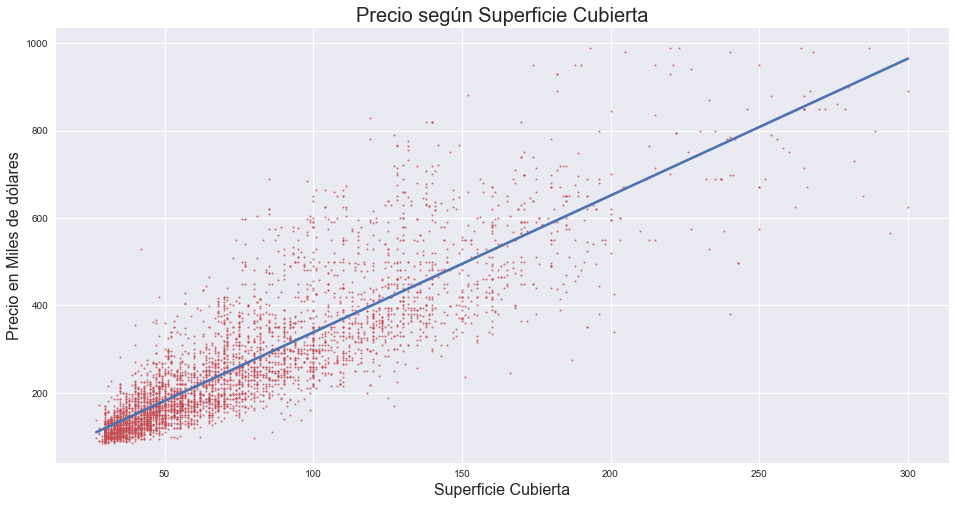

In [17]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.regplot(data=data, x='superficie', y='precio', ci=None, scatter_kws={'color':'r', 's':4}, ax=ax)
ax.set(title='Precio según Superficie Cubierta', 
       ylabel='Precio en Miles de dólares', 
       xlabel='Superficie Cubierta')
plt.show()

---
#### Variables calculadas

In [18]:
data['logprecio'] = np.log(data['precio'])

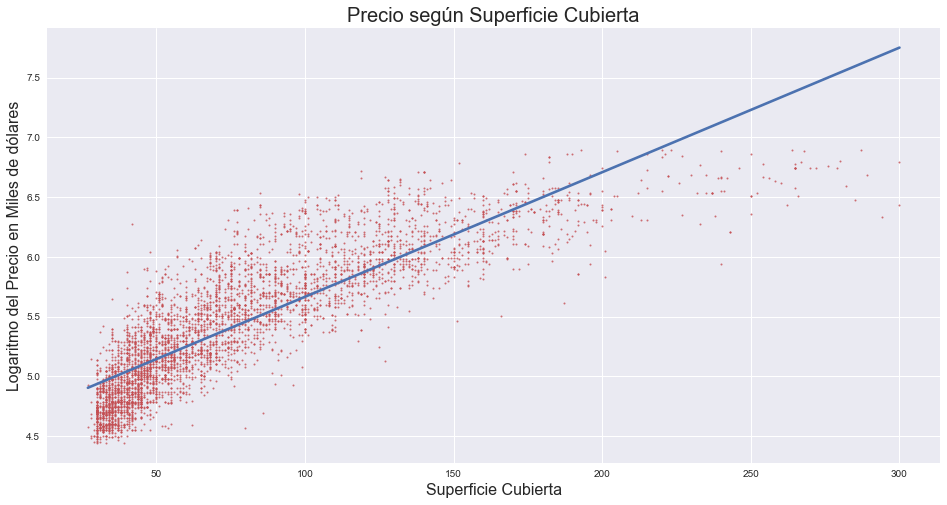

In [19]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.regplot(data=data, x='superficie', y='logprecio', ci=None, scatter_kws={'color':'r', 's':4}, ax=ax)
ax.set(title='Precio según Superficie Cubierta', 
       ylabel='Logaritmo del Precio en Miles de dólares', 
       xlabel='Superficie Cubierta')
plt.show()

---



In [20]:
def train_LinearRegression(X, y) :
    u""" Performs Ordinary Least Squares linear regression
    
    one from Scikit-Learn linear models and two from statsmodels

    Args:
    * X array of array of features
    * y array of target values

    
    
    """
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1)
    
    model = LinearRegression(fit_intercept=True)
    model.fit(Xtrain, ytrain)
    ypred = model.predict(Xtest)
    
    df = pd.DataFrame()
    df = pd.concat([df, pd.DataFrame(columns=['Features'], data=[ str(list(X.columns)) ] )], axis=1)

    df = pd.concat([df, pd.DataFrame(columns=['MAE'], data=[mean_absolute_error(ytest, ypred).round(3)] )], axis=1)
    df = pd.concat([df, pd.DataFrame(columns=['sqrt MSE'], data=[np.sqrt(mean_squared_error(ytest, ypred)).round(3)] )], axis=1)

    
    result_train = sm.OLS(ytrain, sm.add_constant(Xtrain)).fit()    
    r2a_train = result_train.rsquared_adj.round(3)

    result_test = sm.OLS(ytest, sm.add_constant(Xtest)).fit()    
    r2a_test = result_test.rsquared_adj.round(3)
    
    df = pd.concat([df, pd.DataFrame(columns=['R2 adj train'], data=[r2a_train] )], axis=1)
    df = pd.concat([df, pd.DataFrame(columns=['R2 adj test'], data=[r2a_test] )], axis=1)
    
    return model, df

    


---
### Train models


In [21]:
pd.options.display.max_colwidth = 80

In [22]:

y = data['logprecio']
metrics = pd.DataFrame()

data['s2'] = data['superficie'] ** 2


In [23]:

X = data[['superficie']]
model, metric = train_LinearRegression(X, y)
metrics = metrics.append(metric)


In [24]:

X = data[['superficie', 's2']]
model, metric = train_LinearRegression(X, y)
metrics = metrics.append(metric)


In [25]:

X = data[['superficie', 's2','cochera']]
model, metric = train_LinearRegression(X, y)
metrics = metrics.append(metric)


In [26]:

X = data[['superficie', 's2','pileta']]
model, metric = train_LinearRegression(X, y)
metrics = metrics.append(metric)


In [27]:

X = data[['superficie', 's2','parrilla']]
model, metric = train_LinearRegression(X, y)
metrics = metrics.append(metric)


In [28]:

X = data[['superficie', 's2','cochera', 'pileta']]
model, metric = train_LinearRegression(X, y)
metrics = metrics.append(metric)


---

In [29]:
display(metrics.head(20))

,Features,MAE,sqrt MSE,R2 adj train,R2 adj test
0,['superficie'],0.225,0.285,0.719,0.730
0,"['superficie', 's2']",0.204,0.257,0.784,0.781
0,"['superficie', 's2', 'cochera']",0.197,0.251,0.798,0.792
0,"['superficie', 's2', 'pileta']",0.198,0.249,0.805,0.796
0,"['superficie', 's2', 'parrilla']",0.203,0.255,0.787,0.784
0,"['superficie', 's2', 'cochera', 'pileta']",0.195,0.246,0.811,0.801


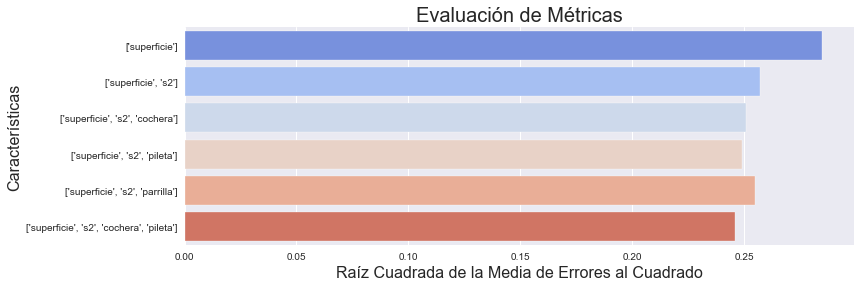

In [30]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x=metrics['sqrt MSE'], y=metrics['Features'], palette='coolwarm', ax=ax)
ax.set(title='Evaluación de Métricas', 
       ylabel='Características', 
       xlabel='Raíz Cuadrada de la Media de Errores al Cuadrado')
plt.show()

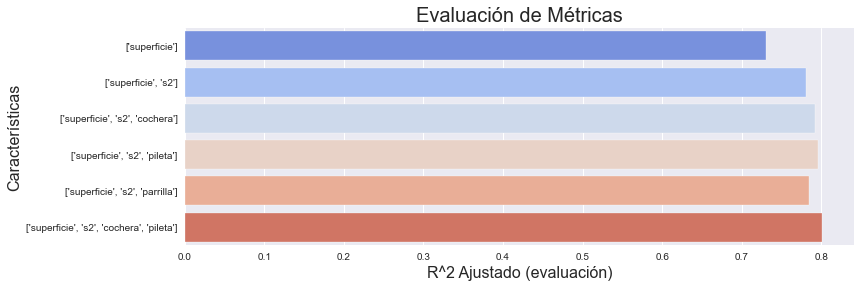

In [31]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(x=metrics['R2 adj test'], y=metrics['Features'], palette='coolwarm', ax=ax)
ax.set(title='Evaluación de Métricas', 
       ylabel='Características', 
       xlabel='R^2 Ajustado (evaluación)')
plt.show()

In [32]:
# departamento de 1 m2 cubierto sin cochera ni pileta
import math
my_X = [[70, 70*70, 0, 0]]
my_y = model.predict(my_X)[0]
display(my_y, math.exp(my_y))

5.336449806225762

207.7737622436875

---
### Gauss-Markov


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              logprecio   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     4982.
Date:                Thu, 28 Apr 2022   Prob (F-statistic):               0.00
Time:                        21:04:33   Log-Likelihood:                 5.3214
No. Observations:                4718   AIC:                           -0.6429
Df Residuals:                    4713   BIC:                             31.65
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1364      0.013    317.266      0.000       4.111       4.162
superficie     0.0203      0.000     75.149      0.000       0.020       0.021
s2         -4.453e-05   1.16e-06    -38.270      0.000   -4.68e-05   -4.23e-05
cochera        0.0921      0.008     12.118      0.000       0.077       0.107
pileta         0.1454      0.008     17.364      0.000       0.129       0.162
==============================================================================
Omnibus:                      168.359   Durbin-Watson:                   1.468
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              204.816
Skew:                           0.414   Prob(JB):                     3.35e-45
Kurtosis:                       3.597   Cond. No.                     4.94e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.94e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

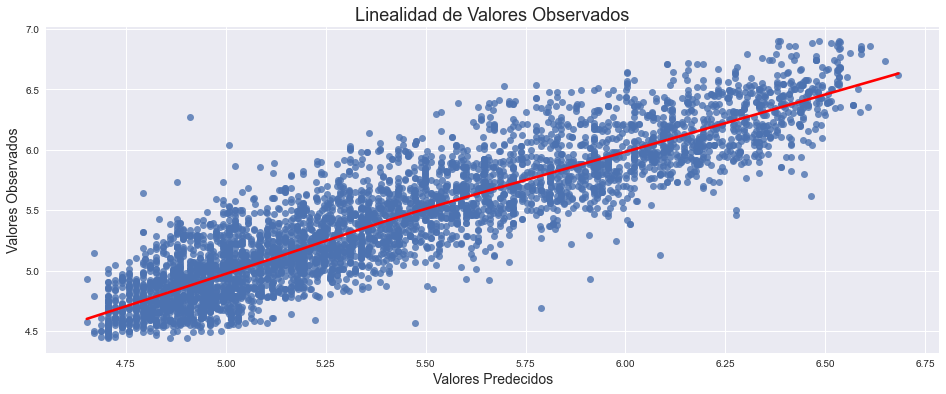

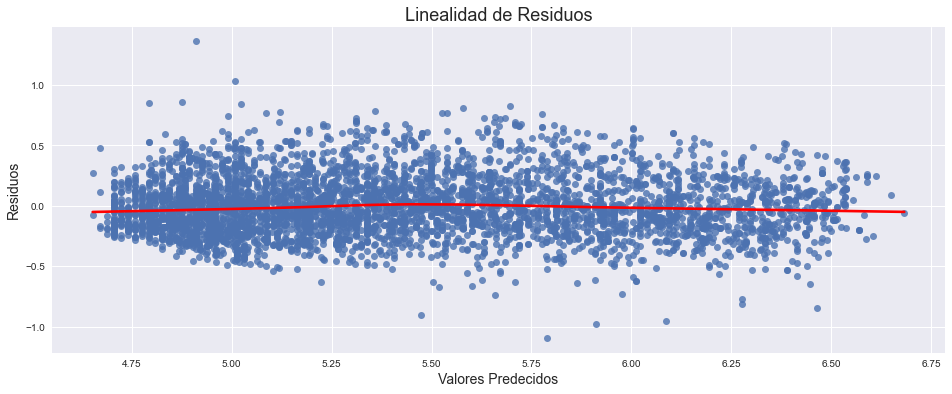

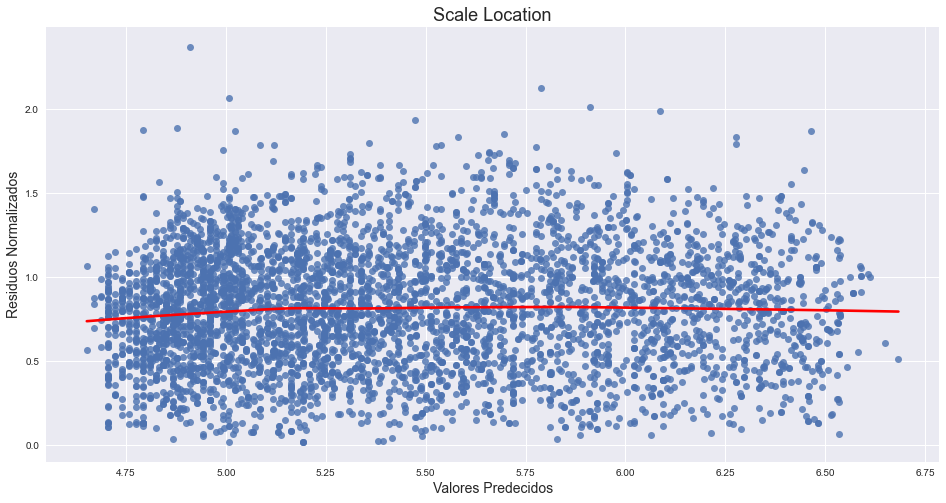

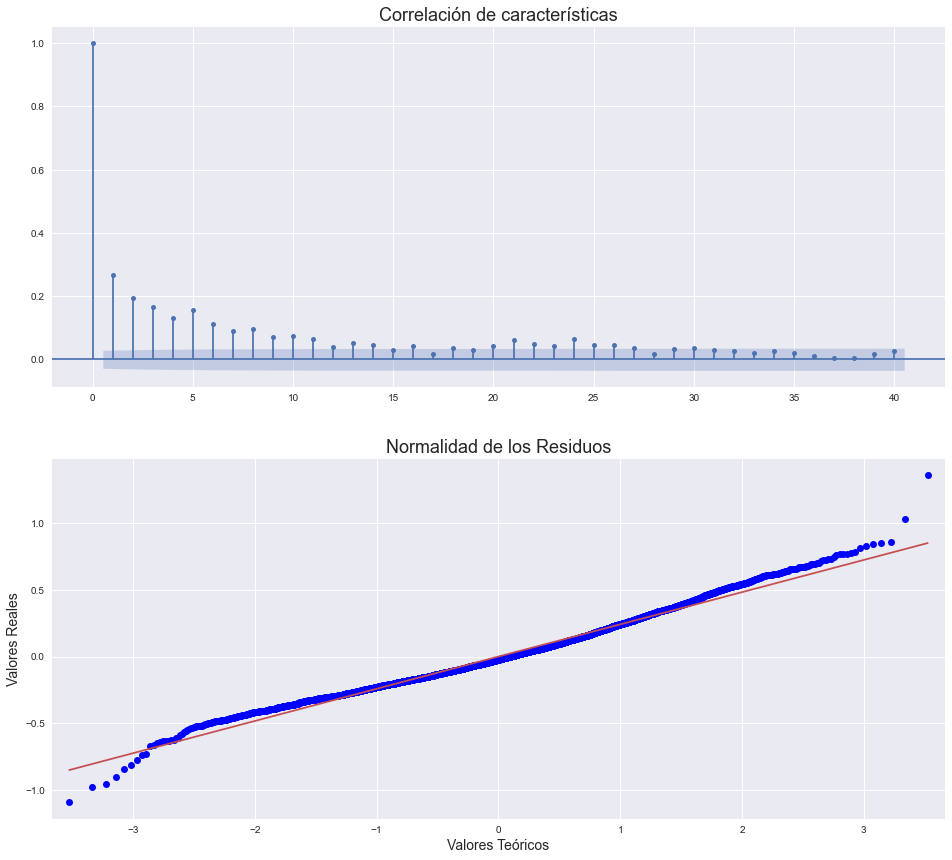

In [33]:
def gauss_markov_test(Xtest, ytest):
    u"""
    funcion para visualizar e identificar supuestos de linealidad sobre la regression lineal
    
    Args:
    * Xtest - bserverd features
    * ytest - observed values
    """
    
    model = sm.OLS(ytest, sm.add_constant(Xtest)).fit()
    
    display(model.summary())
    
    ypred = model.predict()
    resid = model.resid
    rstud = model.get_influence().resid_studentized_internal
    rsqrt = np.sqrt(np.abs(rstud))

    
    plt.figure(figsize=(16, 6))
    sns.regplot(x = ypred, y = ytest, lowess = True, line_kws = {'color': 'red'})
    plt.title('Linealidad de Valores Observados', fontdict = {'fontsize': 18})
    plt.xlabel('Valores Predecidos', fontdict = {'fontsize': 14})
    plt.ylabel('Valores Observados', fontdict = {'fontsize': 14})
    plt.show()

    plt.figure(figsize=(16, 6))
    sns.regplot(x = ypred, y = resid, lowess = True, line_kws = {'color': 'red'})
    plt.title('Linealidad de Residuos', fontdict = {'fontsize': 18})
    plt.xlabel('Valores Predecidos', fontdict = {'fontsize': 14})
    plt.ylabel('Residuos', fontdict = {'fontsize': 14})
    plt.show()
    
    plt.figure(figsize=(16, 8))
    sns.regplot(x = ypred, y = rsqrt, lowess = True, line_kws = {'color': 'red'})
    plt.title('Scale Location', fontdict = {'fontsize': 18})
    plt.xlabel('Valores Predecidos', fontdict = {'fontsize': 14})
    plt.ylabel('Residuos Normalizados', fontdict = {'fontsize': 14})
    plt.show()

    
    sns.mpl.rcParams['figure.figsize'] = (16, 8)
    fig, ax = plt.subplots(2)

    sm.graphics.tsa.plot_acf(x = resid, ax = ax[0], lags = 40 , alpha = 0.05, title = '')
    ax[0].set_title('Correlación de características', fontdict = {'fontsize': 18})

    plt.subplots_adjust(top = 1.5, wspace = 2)

    sm.ProbPlot(model.resid).qqplot(ax = ax[1], line = 's')
    ax[1].set_title('Normalidad de los Residuos', fontdict = {'fontsize': 18})
    ax[1].set_xlabel("Valores Teóricos", fontsize = 14)
    ax[1].set_ylabel("Valores Reales", fontsize = 14)
    plt.show()
    
    return


X = data[['superficie', 's2', 'cochera', 'pileta']]
y = data['logprecio']

gauss_markov_test(X, y)


---